# Comparison of H2 and stellar surface density

In [1]:
import os
import numpy as np
from astropy.table import Table, join, Column
import matplotlib.pyplot as plt
from astropy import units as u
from scipy import stats
import edge_pydb
from edge_pydb.edge_conv import gc_polr, stmass_pc2, msd_co, ZOH_M13, xy2hist
params = {'mathtext.default': 'regular'} 
plt.rcParams.update(params)
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Read the observational values

In [2]:
try:
    hafile = edge_pydb.getfiles('edge.pipe3d.hdf5')
    cofile = edge_pydb.getfiles('edge.comom_smo7.hdf5')
    print('Working on full EDGE database')
except:
    print('Working on NGC 4047 data')
    hafile = edge_pydb.getfiles('NGC4047.pipe3d.hdf5')
    cofile = edge_pydb.getfiles('NGC4047.comom_smo7.hdf5')

Working on NGC 4047 data


In [3]:
cotab  = Table.read(cofile, path='smo')
hatab  = Table.read(hafile, path='flux_elines_sm')
ssp_sm = Table.read(hafile, path='SSP_sm')
join2  = join(join(cotab,hatab),ssp_sm)
# For stellar surface density we need distance
# globaldir = '../dat_glob/'
califa  = Table.read(edge_pydb.getfiles('edge_califa.csv'), format='ascii.ecsv')
dists   = Table([califa['Name'], califa['caDistMpc']])
join3   = join(join2, dists, keys='Name')
# For normalized radius we need R25 and center position
coflux  = Table.read(edge_pydb.getfiles('edge_coflux_smo7.csv'), format='ascii.ecsv')
radec   = Table([coflux['Name'], coflux['coRactr_smo7'], coflux['coDectr_smo7']])
join4   = join(join3, radec, keys='Name')
leda    = Table.read(edge_pydb.getfiles('edge_leda.csv'), format='ascii.ecsv')
r25tab  = Table([leda['Name'], leda['ledaD25'], leda['ledaPA'], leda['ledaIncl']])
alltab  = join(join4, r25tab, keys='Name')
print(alltab.colnames)

['Name', 'ix', 'iy', 'ra_off', 'dec_off', 'rad_arc', 'azi_ang', 'emom0max', 'mom0', 'emom0', 'flux_[OII]3727', 'flux_[OIII]5007', 'flux_[OIII]4959', 'flux_Hbeta', 'flux_Halpha', 'flux_[NII]6583', 'flux_[NII]6548', 'flux_[SII]6717', 'flux_[SII]6731', 'vel_[OII]3727', 'vel_[OIII]5007', 'vel_[OIII]4959', 'vel_Hbeta', 'vel_Halpha', 'vel_[NII]6583', 'vel_[NII]6548', 'vel_[SII]6717', 'vel_[SII]6731', 'disp_[OII]3727', 'disp_[OIII]5007', 'disp_[OIII]4959', 'disp_Hbeta', 'disp_Halpha', 'disp_[NII]6583', 'disp_[NII]6548', 'disp_[SII]6717', 'disp_[SII]6731', 'EW_[OII]3727', 'EW_[OIII]5007', 'EW_[OIII]4959', 'EW_Hbeta', 'EW_Halpha', 'EW_[NII]6583', 'EW_[NII]6548', 'EW_[SII]6717', 'EW_[SII]6731', 'e_flux_[OII]3727', 'e_flux_[OIII]5007', 'e_flux_[OIII]4959', 'e_flux_Hbeta', 'e_flux_Halpha', 'e_flux_[NII]6583', 'e_flux_[NII]6548', 'e_flux_[SII]6717', 'e_flux_[SII]6731', 'e_vel_[OII]3727', 'e_vel_[OIII]5007', 'e_vel_[OIII]4959', 'e_vel_Hbeta', 'e_vel_Halpha', 'e_vel_[NII]6583', 'e_vel_[NII]6548', 'e_

## Calculate physical values using functions in edge_conv.py

In [4]:
ZOH = ZOH_M13(alltab, method='o3n2', err=False)
print('Calculated {} for {} points'.format('ZOH',len(ZOH)))
sig_star = stmass_pc2(alltab['mass_ssp'], dist=alltab['caDistMpc'].quantity)
print('Calculated {} for {} points'.format('sig_star',len(sig_star)))
sig_mol  = msd_co(alltab['mom0'])
print('Calculated {} for {} points'.format('sig_mol',len(sig_mol)))
sig_molerr = msd_co(alltab['emom0'], name='sig_molerr')
print('Calculated {} for {} points'.format('sig_molerr',len(sig_molerr)))

Calculated ZOH for 266855 points
Calculated sig_star for 266855 points
Calculated sig_mol for 266855 points
Calculated sig_molerr for 266855 points


In [5]:
# Skip, we can now use pre-calculated values.
# rarc, _ = gc_polr(alltab['coRactr_smo7']+alltab['ra_off'], 
#                   alltab['coDectr_smo7']+alltab['dec_off'], 
#                   alltab['coRactr_smo7'], alltab['coDectr_smo7'],
#                   np.array(alltab['ledaPA']), 
#                   np.array(alltab['ledaIncl']))
# r25 = 0.5*(alltab['ledaD25'].quantity).to(u.arcsec)
# rr25 = Column(data=rarc/r25.value, unit=None, name='rr25')
# print('Calculated {} for {} points'.format('rr25',len(rr25)))

In [6]:
r25 = 0.5*(alltab['ledaD25'].quantity).to(u.arcsec)
rr25 = Column(data=alltab['rad_arc']/r25.value, unit=None, name='rr25')
print('Calculated {} for {} points'.format('rr25',len(rr25)))

Calculated rr25 for 266855 points


In [7]:
alltab.add_columns([sig_star, sig_mol, sig_molerr, ZOH, rr25])
print(alltab.colnames)

['Name', 'ix', 'iy', 'ra_off', 'dec_off', 'rad_arc', 'azi_ang', 'emom0max', 'mom0', 'emom0', 'flux_[OII]3727', 'flux_[OIII]5007', 'flux_[OIII]4959', 'flux_Hbeta', 'flux_Halpha', 'flux_[NII]6583', 'flux_[NII]6548', 'flux_[SII]6717', 'flux_[SII]6731', 'vel_[OII]3727', 'vel_[OIII]5007', 'vel_[OIII]4959', 'vel_Hbeta', 'vel_Halpha', 'vel_[NII]6583', 'vel_[NII]6548', 'vel_[SII]6717', 'vel_[SII]6731', 'disp_[OII]3727', 'disp_[OIII]5007', 'disp_[OIII]4959', 'disp_Hbeta', 'disp_Halpha', 'disp_[NII]6583', 'disp_[NII]6548', 'disp_[SII]6717', 'disp_[SII]6731', 'EW_[OII]3727', 'EW_[OIII]5007', 'EW_[OIII]4959', 'EW_Hbeta', 'EW_Halpha', 'EW_[NII]6583', 'EW_[NII]6548', 'EW_[SII]6717', 'EW_[SII]6731', 'e_flux_[OII]3727', 'e_flux_[OIII]5007', 'e_flux_[OIII]4959', 'e_flux_Hbeta', 'e_flux_Halpha', 'e_flux_[NII]6583', 'e_flux_[NII]6548', 'e_flux_[SII]6717', 'e_flux_[SII]6731', 'e_vel_[OII]3727', 'e_vel_[OIII]5007', 'e_vel_[OIII]4959', 'e_vel_Hbeta', 'e_vel_Halpha', 'e_vel_[NII]6583', 'e_vel_[NII]6548', 'e_

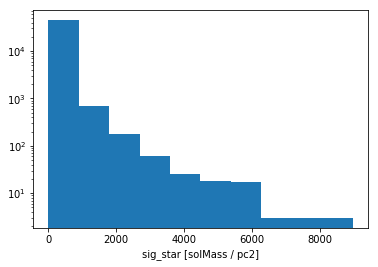

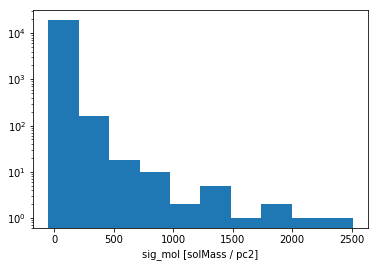

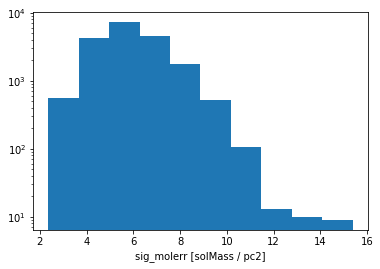

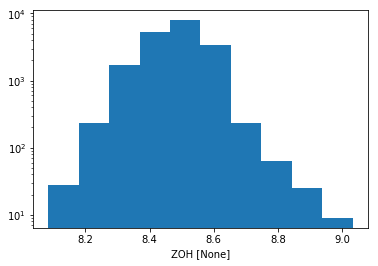

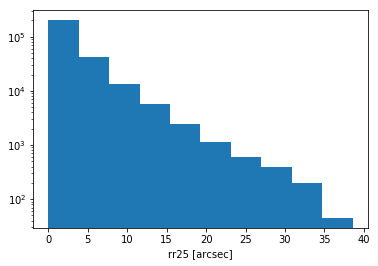

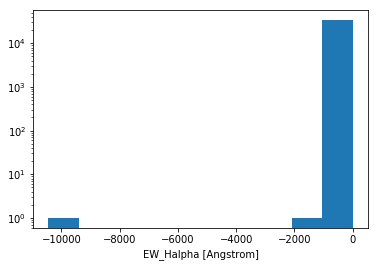

In [8]:
for column in ['sig_star', 'sig_mol', 'sig_molerr', 'ZOH', 'rr25', 'EW_Halpha']:
    not_nan = (~np.isnan(alltab[column]))
    plt.hist(alltab[column][not_nan],log=True)
    plt.xlabel(column+' ['+str(alltab[column].unit)+']')
    plt.show()
    plt.close()

## Make the plots

In [9]:
# Plot limits and labels
xlabel = '$\Sigma_*\ [M_\odot\, pc^{-2}]$'
ylabel = '$\Sigma_{H2}\ [M_\odot\, pc^{-2}]$'
xrange = [0, 4]
yrange = [0, 4]

# 10% line
xsca = np.logspace(xrange[0],xrange[1],100)
ysca = xsca/10.

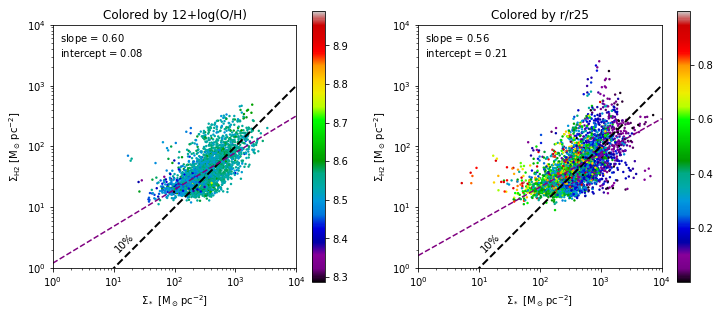

In [10]:
# Scatter X vs Y colored by Z, CO detections only
fig, ax = plt.subplots(1,2,figsize=(12,5))
cmap = plt.cm.get_cmap('nipy_spectral')
for i, zcolumn in enumerate(['ZOH', 'rr25']):
    xdata = alltab['sig_star']
    ydata = alltab['sig_mol']
    zdata = alltab[zcolumn]
    goodidx = (xdata>0) & (ydata>0) & (zdata>0) & (alltab['rr25']<1)
    detidx = goodidx & (alltab['sig_mol']>3*alltab['sig_molerr'])
    xdata = xdata[detidx]
    ydata = ydata[detidx]
    zdata = zdata[detidx]
    sc = ax[i].scatter(xdata, ydata, marker='o', c=zdata, edgecolors='none', s=6, cmap=cmap)
    # Plot 10% line
    ax[i].plot(xsca, ysca, linestyle='--', lw=2, color='k')
    ax[i].text(10, 3, '10%', rotation=45)
    # Plot colorbar
    fig.colorbar(sc, ax=ax[i])
    # Plot linear regression
    sorted=np.argsort(xdata)
    m, b, rval, pval, std_err = stats.linregress(np.log10(xdata[sorted]),
        np.log10(ydata[sorted]))
    ymod = b+m*np.log10(xsca)
    ax[i].plot(xsca, 10**(ymod), linestyle='--', color='purple')
    ax[i].text(0.03,0.93,'slope = $%4.2f$' % m,size=10,transform=ax[i].transAxes)
    ax[i].text(0.03,0.87,'intercept = $%4.2f$' % b,size=10,transform=ax[i].transAxes)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    if i==0:
        title='12+log(O/H)'
    else:
        title='r/r25'
    ax[i].set_title('Colored by '+title)
    ax[i].set_xlim(10**xrange[0], 10**xrange[1])
    ax[i].set_ylim(10**yrange[0], 10**yrange[1])
    ax[i].set_xlabel(xlabel)
    ax[i].set_ylabel(ylabel)
    ax[i].set_aspect('equal')
plt.show()

Excluding 262944 invalid values
Number of detection points: 3911


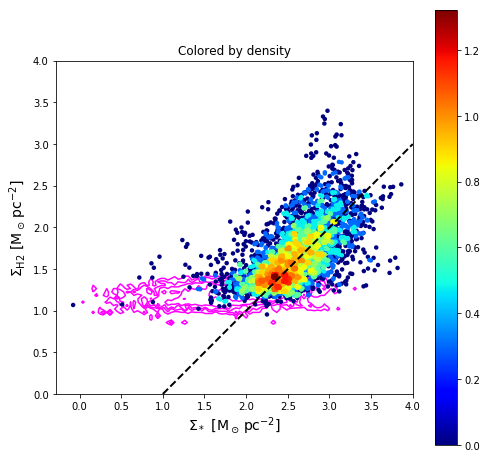

In [11]:
# Histogram of X vs Y
det = ((~np.isnan(alltab['sig_star'])) & 
       (~np.isnan(alltab['sig_mol'])) & 
       (alltab['sig_mol']>3*alltab['sig_molerr']) &
       (alltab['sig_star']>0))
print('Excluding {} invalid values'.format(len(np.nonzero(~det)[0])))
print('Number of detection points:',len(np.nonzero(det)[0]))
x_det, y_det, z_det, *hist = xy2hist(alltab['sig_star'][det], alltab['sig_mol'][det], log=True)

# Plot the detections as colored points
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap=cm, zorder=2)

# Plot the upper limits as contours
nbins = 100
xbins = np.linspace(xrange[0], xrange[1], nbins)
ybins = np.linspace(yrange[0], yrange[1], nbins)
ulim = ((alltab['sig_star']>0) & 
        ((np.isnan(alltab['sig_mol'])) | (alltab['sig_mol']<3*alltab['sig_molerr'])))
H2, xedges, yedges = np.histogram2d(np.log10(alltab['sig_star'][ulim]),
                                      np.log10(3*alltab['sig_molerr'][ulim]),
                                      bins=(xbins,ybins))
H2 = np.transpose(H2)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
levels = [2, 5, 10, 20, 50, 100, 200]
cmap = ax.contour(H2, colors='magenta', extent=extent, levels=levels, zorder=1)

# Plot the 10% line
xsca = np.linspace(1,4,10)
ysca = xsca - 1
ax.plot(xsca, ysca, linestyle='--', lw=2, color='k')

plt.xlabel(xlabel,fontsize=14)
plt.ylabel(ylabel,fontsize=14)
ax.set_title('Colored by density')
ax.set_aspect('equal')
plt.colorbar(sc)